# Dropout Prediction EDA

In [35]:
import pandas as pd
import numpy as np
from hashlib import sha1
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [2]:
data_path = '../data/raw/data.csv'
sep = ';'

In [3]:
df = pd.read_csv(data_path, sep=sep)
df = df.rename(columns={'Nacionality': 'Nationality'})
df.shape

(4424, 37)

In [4]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
df.tail()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate
4423,1,10,1,9773,1,1,152.0,22,38,37,...,0,6,6,6,13.000000,0,12.7,3.7,-1.70,Graduate


In [6]:
df = df.dropna()
df.shape

(4424, 37)

The data-set consists of 4424 records with 35 attributes and contains no missing values. The distribution and statistics are above and below.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nationality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

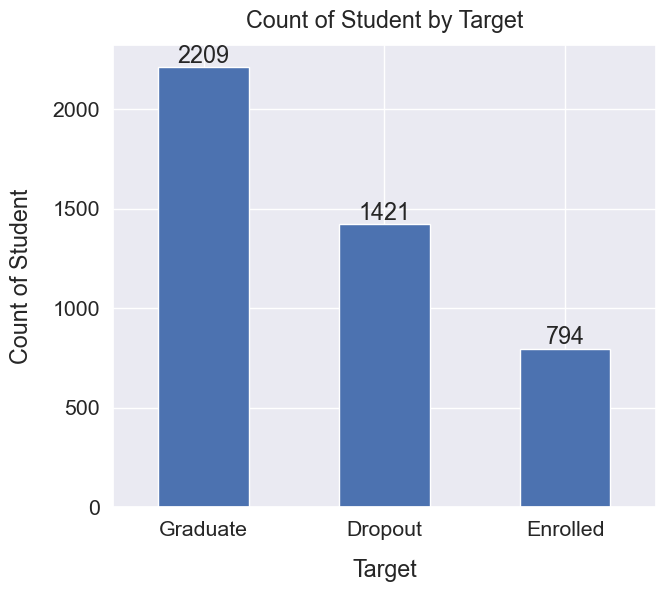

In [8]:

sns.set(font_scale=1.4)
ax = df['Target'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
ax.bar_label(ax.containers[0])
plt.xlabel("Target", labelpad=14)
plt.ylabel("Count of Student", labelpad=14)
plt.title("Count of Student by Target", y=1.02);

From above plot, we can see this problem was three-category classification task, and there exists strong imbalance between those three classes. The class, Graduate, has the majority count which is around 50% of the records and Dropout has 32% of total records. The Enrolled only has 18% of total records. Thus, during our training, we need to find a way to fix this imbalance issues.

## Dropping Enrolled Student

In [9]:
df = df.drop(df[df.Target == 'Enrolled'].index)
df.shape

(3630, 37)

In [10]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nationality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

In [11]:

numeric_cols = ['Marital status', 'Nationality','Displaced','Gender',
                'Age at enrollment', 'International',
                "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation",
                
       'Educational special needs', 'Debtor',
       'Tuition fees up to date',  'Scholarship holder',
        'Unemployment rate','Inflation rate', 'GDP',
                
        'Application mode', 'Application order', 'Course',
                
       'Daytime/evening attendance\t', 'Previous qualification',
       #'Previous qualification (grade)', 
       # 'Admission grade',
        
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', ]
df[numeric_cols].corr('spearman').style.background_gradient()

,Marital status,Nationality,Displaced,Gender,Age at enrollment,International,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Educational special needs,Debtor,Tuition fees up to date,Scholarship holder,Unemployment rate,Inflation rate,GDP,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations)
Marital status,1.000000,-0.029151,-0.280670,0.034059,0.487771,-0.029312,0.185557,0.117648,0.107951,0.046720,-0.030775,0.038310,-0.104008,-0.111171,-0.039405,0.003924,-0.073733,0.283749,-0.181021,0.010963,-0.349339,0.198423,0.101918,-0.003613,0.060678,-0.074359,-0.098640,0.049069,0.098985,-0.025889,0.012913,-0.080764,-0.096833,0.059087
Nationality,-0.029151,1.000000,-0.000933,-0.032763,0.014973,0.999910,-0.016578,-0.071854,0.016602,0.025482,0.000875,0.069663,-0.055761,-0.019974,-0.007001,-0.001856,0.031021,-0.001916,-0.018081,0.006666,0.032564,-0.040163,0.023905,-0.003167,-0.008466,-0.002099,0.000291,-0.010229,0.022434,-0.011215,-0.027296,-0.016196,-0.002299,-0.023510
Displaced,-0.280670,-0.000933,1.000000,-0.127896,-0.358344,-0.000790,-0.056694,-0.049759,-0.030864,-0.025477,-0.005099,-0.093718,0.105403,0.086337,-0.116721,-0.005004,0.064342,-0.275745,0.391173,0.012632,0.243653,-0.205442,-0.129085,0.016764,-0.051751,0.096292,0.096843,-0.030897,-0.132305,0.033914,-0.019175,0.094870,0.087677,-0.046051
Gender,0.034059,-0.032763,-0.127896,1.000000,0.217921,-0.032755,-0.046191,-0.061476,-0.023081,-0.024909,-0.009794,0.052770,-0.122231,-0.187994,0.021554,-0.007236,-0.024112,0.172056,-0.125412,-0.091264,-0.030507,0.099248,0.027893,-0.192456,-0.033322,-0.249881,-0.186811,0.004499,0.029235,-0.198612,-0.058061,-0.262117,-0.205081,0.070138
Age at enrollment,0.487771,0.014973,-0.358344,0.217921,1.000000,0.014839,0.171158,0.091516,0.088996,0.033188,-0.026482,0.130889,-0.218685,-0.236935,0.011000,0.021894,-0.062735,0.560823,-0.374271,-0.094831,-0.419255,0.408268,0.303084,-0.022160,0.160976,-0.204002,-0.243264,0.079966,0.302135,-0.057878,0.061485,-0.222433,-0.246500,0.116112
International,-0.029312,0.999910,-0.000790,-0.032755,0.014839,1.000000,-0.016059,-0.071386,0.016114,0.025357,0.000908,0.069682,-0.055777,-0.020298,-0.007136,-0.001865,0.030689,-0.001597,-0.018055,0.006865,0.032494,-0.039960,0.023964,-0.002866,-0.008153,-0.001856,0.000368,-0.010031,0.022549,-0.011010,-0.026901,-0.015868,-0.002015,-0.023427
Mother's qualification,0.185557,-0.016578,-0.056694,-0.046191,0.171158,-0.016059,1.000000,0.445642,0.348163,0.170351,-0.008903,0.005673,-0.014049,0.025692,-0.093304,0.040142,-0.080006,0.069950,-0.047869,0.035886,-0.145697,0.015110,-0.001530,0.021331,0.043886,-0.023753,-0.053202,0.000099,-0.000300,0.005997,0.021302,-0.017841,-0.045127,0.030562
Father's qualification,0.117648,-0.071854,-0.049759,-0.061476,0.091516,-0.071386,0.445642,1.000000,0.253224,0.238990,0.008903,-0.002821,-0.006175,0.103427,-0.042213,0.044264,-0.048976,0.053402,-0.053601,0.027512,-0.087955,0.019405,-0.002937,0.014720,0.039595,0.006939,-0.011165,-0.003496,0.002823,0.007058,0.004523,0.014340,-0.013010,-0.004622
Mother's occupation,0.107951,0.016602,-0.030864,-0.023081,0.088996,0.016114,0.348163,0.253224,1.000000,0.486733,-0.005339,0.069890,-0.039185,0.139340,0.021428,0.048046,0.022603,0.022016,-0.035739,0.018485,-0.059897,-0.014170,-0.019444,0.005313,-0.017714,0.000808,-0.023689,-0.016032,-0.025439,0.004591,-0.016173,0.019376,0.003618,0.003117
Father's occupation,0.046720,0.025482,-0.025477,-0.024909,0.033188,0.025357,0.170351,0.238990,0.486733,1.000000,-0.003798,

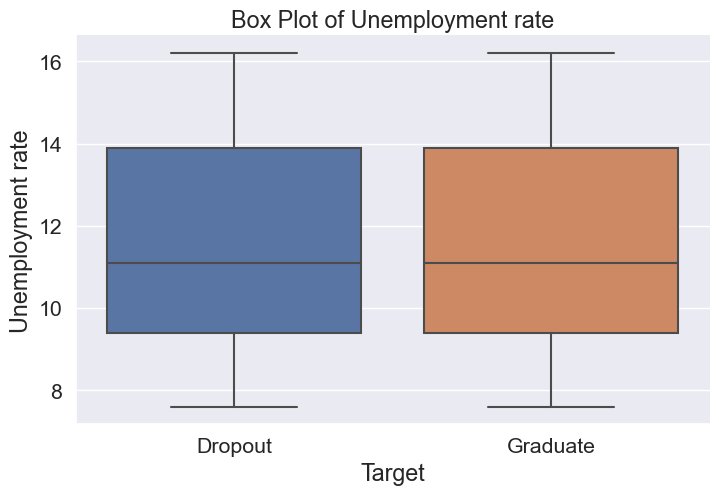

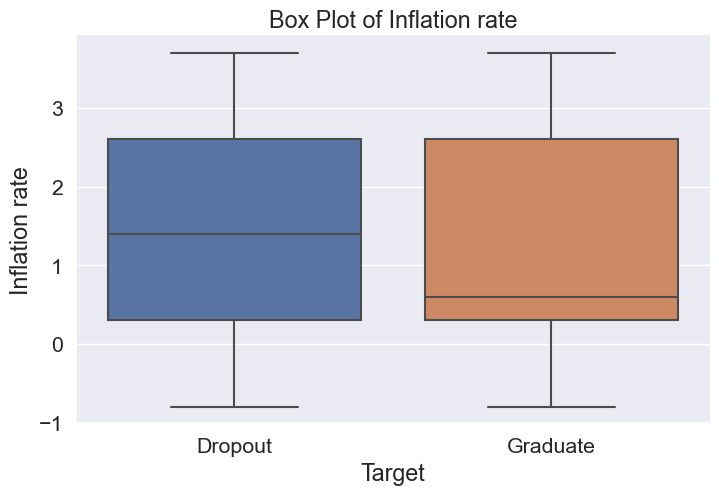

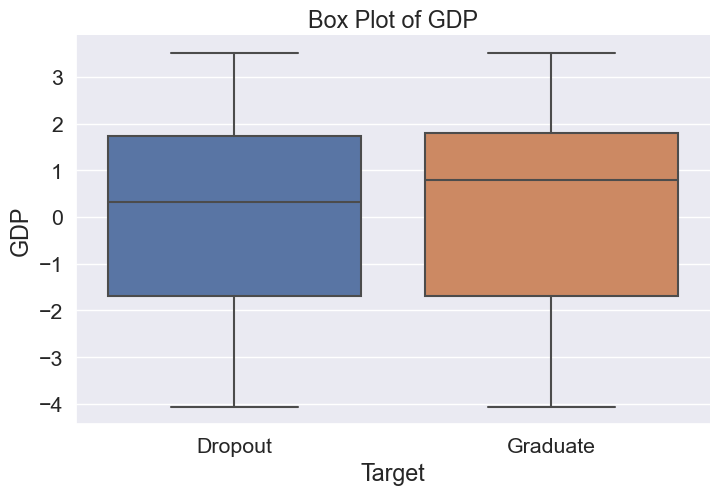

In [12]:
macroeconomic_col = ['Unemployment rate','Inflation rate', 'GDP']

for i in range(0, len(macroeconomic_col)):

    sns.catplot(x='Target', y=macroeconomic_col[i], data=df, kind="box", aspect=1.5)
    plt.title("Box Plot of " + macroeconomic_col[i])
    


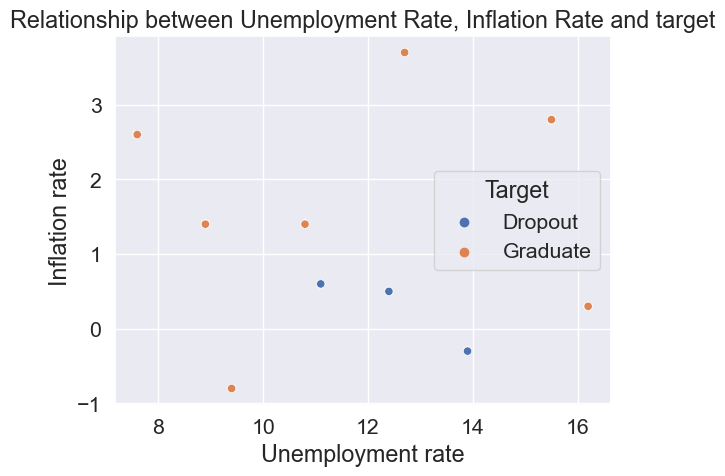

In [13]:
sns.scatterplot(x='Unemployment rate', y='Inflation rate', hue="Target", data=df)
plt.title("Relationship between Unemployment Rate, Inflation Rate and target")
plt.show()

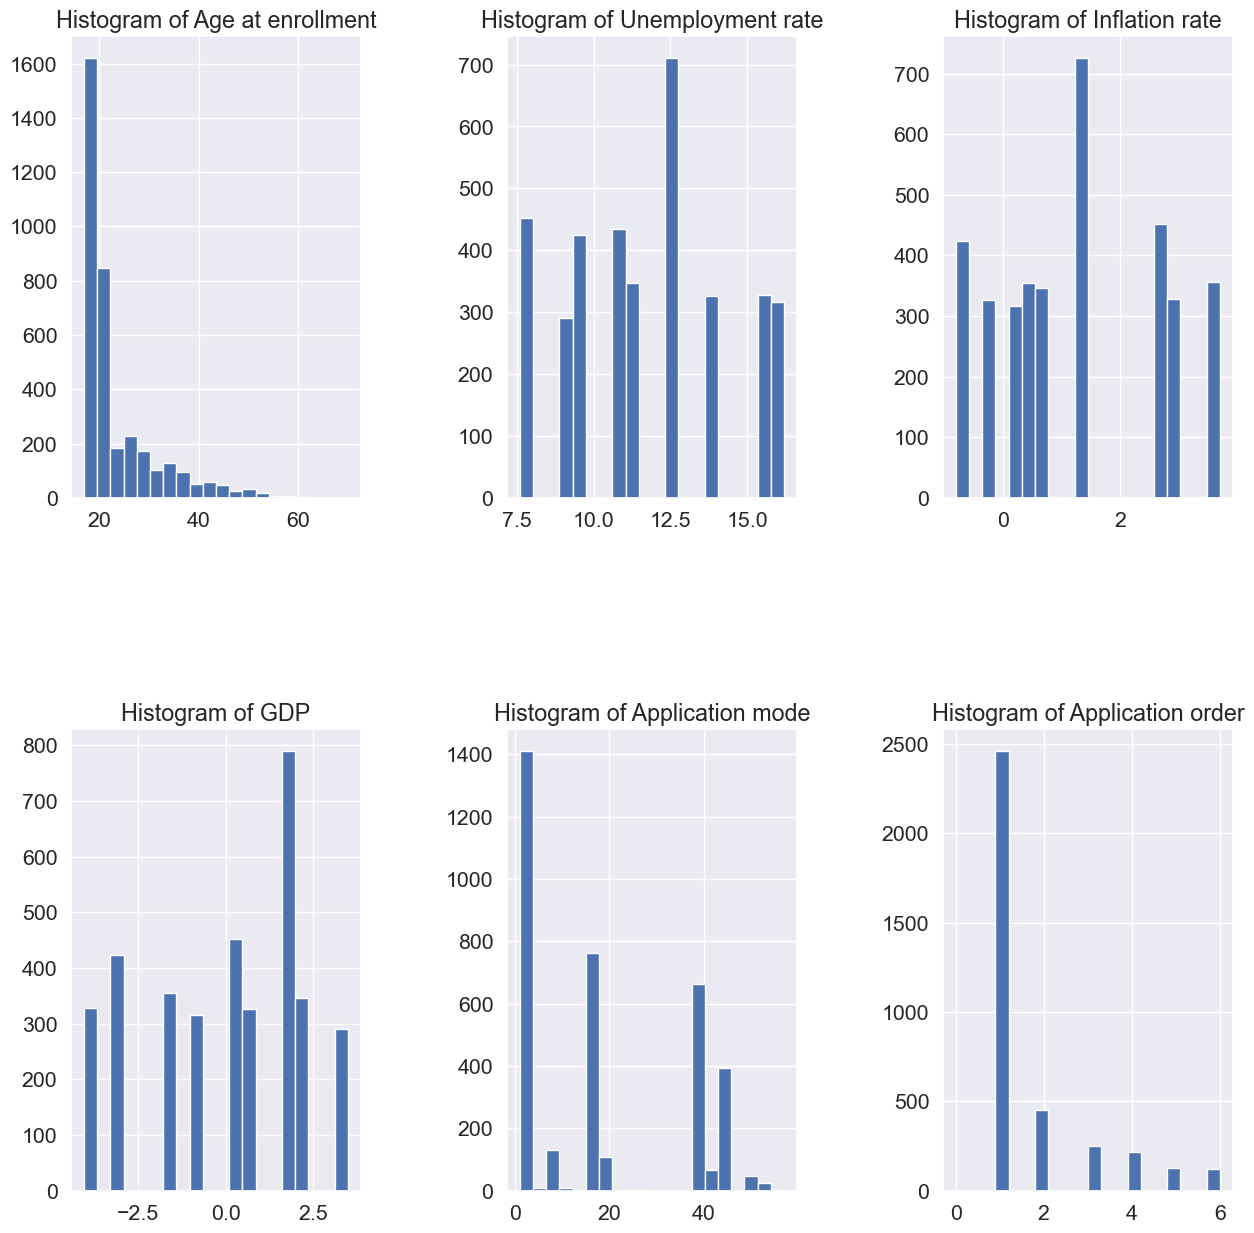

In [14]:
numeric_cols = ['Age at enrollment',
                'Unemployment rate','Inflation rate', 'GDP',
        'Application mode', 'Application order' 
        ]

fig, axs = plt.subplots(2,3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()

for i in range(0, len(numeric_cols)):

    axs[i].hist(df[numeric_cols[i]], bins=20)
    axs[i].set_title("Histogram of " + numeric_cols[i])

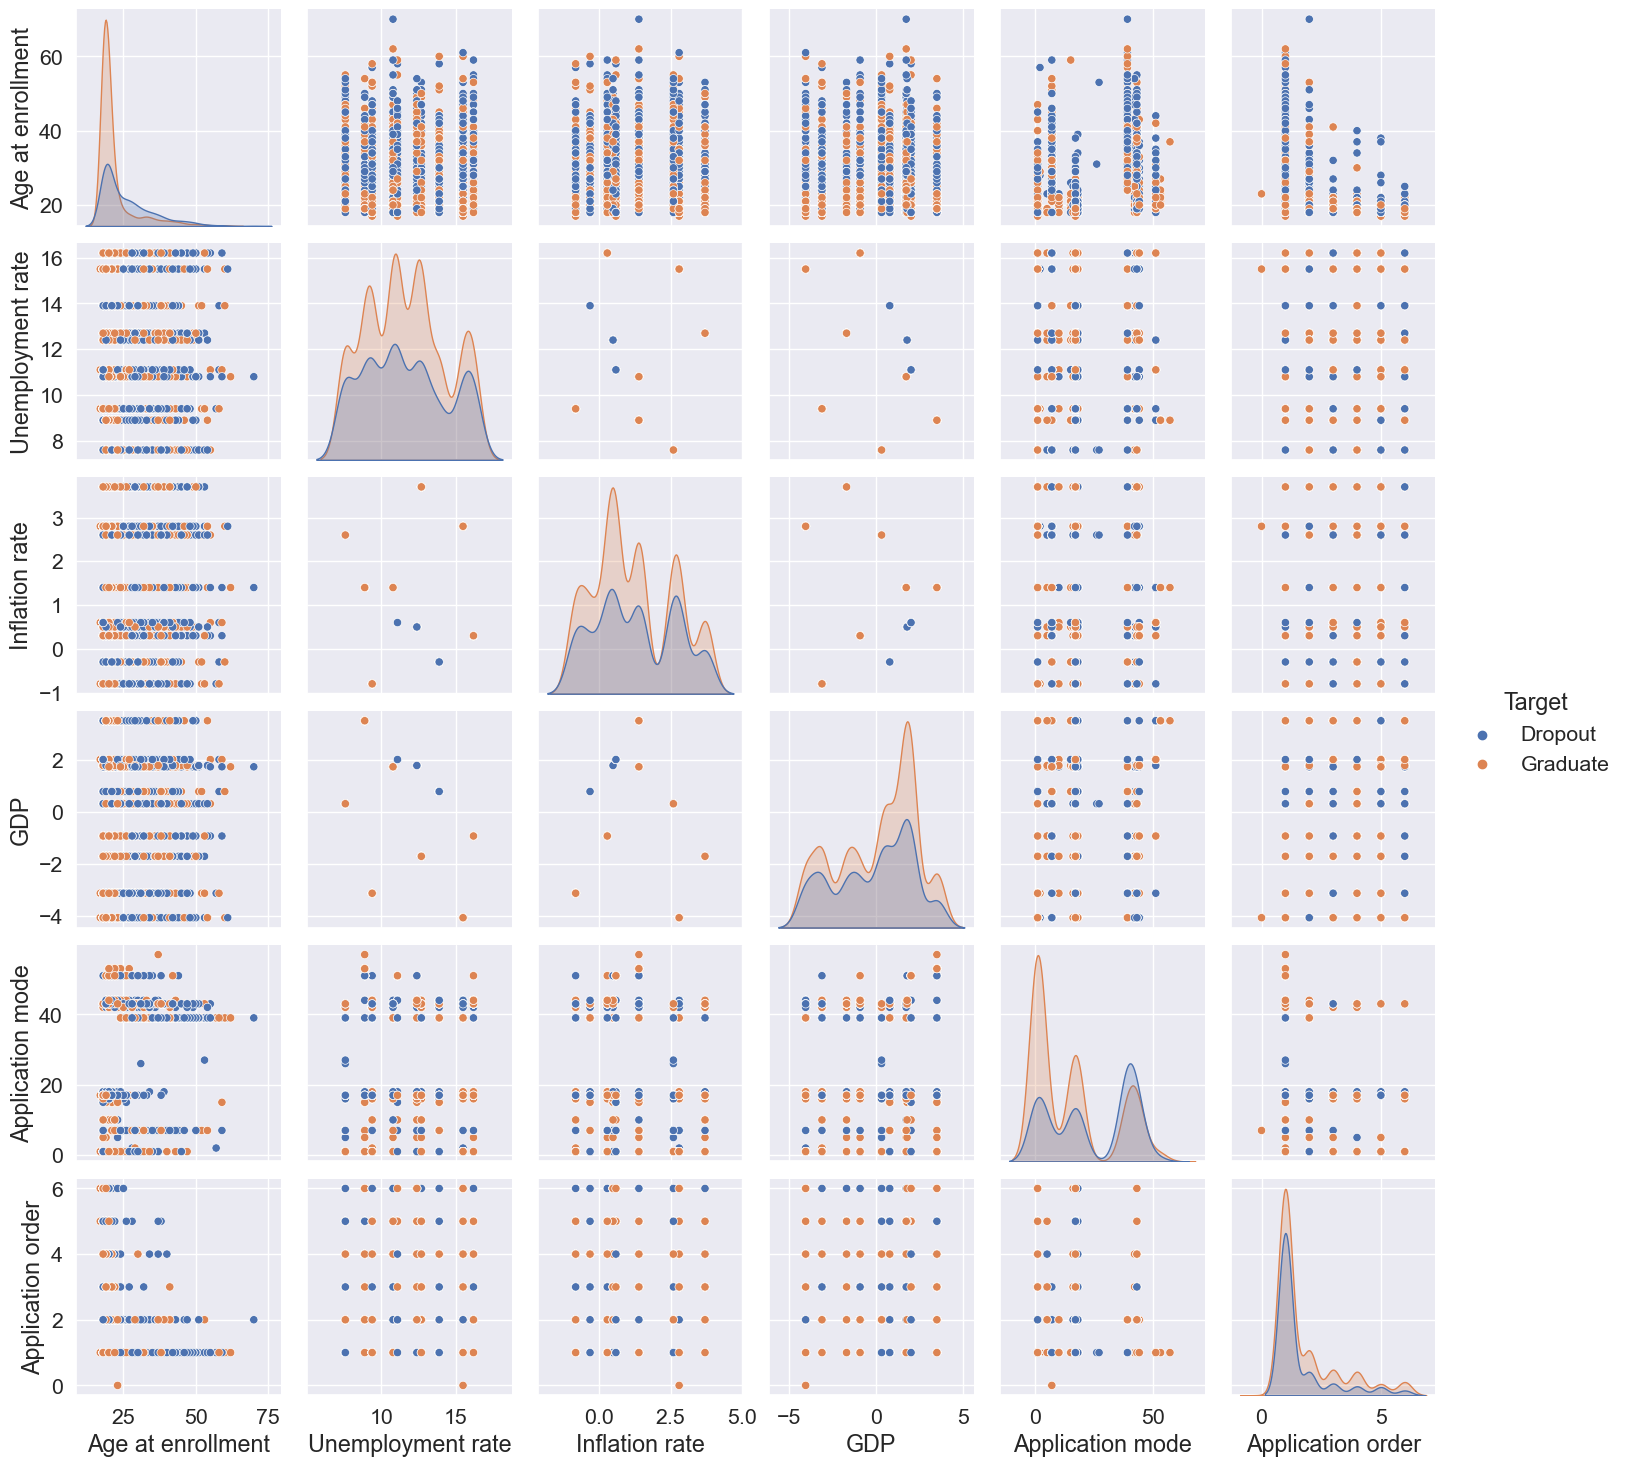

In [15]:
sns.pairplot(df[['Age at enrollment',
                'Unemployment rate','Inflation rate', 'GDP',
        'Application mode', 'Application order' , 'Target']],
            hue='Target')

In [41]:
numeric_cols = df.select_dtypes('number').columns.tolist()
numeric_cols

# performance of two semester vs Target


df_new = df[['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Target']]

first_sem = ['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)']

second_sem = ['Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)']

alt.Chart(df_new).mark_point().encode(
     alt.X(alt.repeat('column'), type='quantitative'),
     alt.Y(alt.repeat('row'), type='quantitative'),
     color = 'Target'
).properties(
    width=200,
    height=200
).repeat(
    row = first_sem,
    column = second_sem
)


alt.RepeatChart(...)